# Clustering 

In [1]:
# general imports
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# for agglomerative clustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

# for linear regression and metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# read in the data
data = pd.read_csv('Datasets/calcofi_combined.csv')
data.head()

,Cst_Cnt,Sta_ID,ChlorA,Phaeop,T_degC,Salnty,O2ml_L,PO4uM,SiO3uM,NO3uM,...,Month,Julian_Day,Lat_Dec,Lon_Dec,Julian_Date,Wind_Spd,Wave_Ht,Dry_T,Wave_Prd,Barometer
0,18832,133.0 035.0,0.650000,0.425000,13.172667,34.336533,2.785000,NaN,NaN,14.103333,...,3,67,25.850000,-113.500000,26731.0,12.0,3.0,19.0,6.0,1001.6
1,18833,142.7 008.0,2.483333,1.103333,16.316316,34.930211,2.298421,NaN,27.489474,NaN,...,3,69,25.026666,-110.750000,26733.0,7.0,NaN,19.2,NaN,1001.7
2,18834,142.0 008.0,0.240000,3.330000,14.762400,34.833250,2.067200,NaN,NaN,NaN,...,3,69,25.093333,-110.783333,26733.0,4.0,1.0,20.6,3.0,1001.7
3,18835,120.0 010.0,2.425000,2.483000,15.270000,NaN,3.535000,1.812,31.675000,NaN,...,3,70,28.856666,-113.258333,26734.0,15.0,1.0,18.8,1.0,1001.0
4,18836,120.0 009.0,5.540909,2.557273,14.281923,NaN,2.874615,NaN,NaN,NaN,...,3,71,28.878333,-113.191666,26735.0,10.0,1.0,18.9,2.0,1000.8


## Agglomerative clustering

In [4]:
combined_data = pd.read_csv('Datasets/combined_data.csv')

# Select columns for clustering with low missing values and perform median imputation
#selected_vars = ['T_degC', 'Salnty', 'Depthm', 'Wind_Spd']  # These have minimal missing values
selected_vars = ['ChlorA']  # These have minimal missing values
data_for_clustering = combined_data[selected_vars]
# imputer = SimpleImputer(strategy='median')
# data_imputed = pd.DataFrame(imputer.fit_transform(data_for_clustering), columns=selected_vars)

# Standardize the data
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data_imputed)

# Apply hierarchical clustering
#linked = linkage(data_scaled, method='ward')
linked = linkage(data_for_clustering, method='ward')

plt.figure(figsize=(20, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           truncate_mode='lastp',  # Truncates the dendrogram to show the last p clusters
           p=113)  # Adjust 'p' to show the desired number of clusters
plt.title('Dendrogram')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.tick_params(axis='x', labelsize=12)
plt.show()

ValueError: The condensed distance matrix must contain only finite values.

In [10]:
# Perform hierarchical clustering and create 6 clusters
linked = linkage(data_scaled, method='ward')
combined_data['Cluster'] = fcluster(linked, 6, criterion='maxclust')

# Prepare a summary report
imputation_summary = []

# Impute missing values within each cluster
imputed_data = combined_data.copy()
for cluster_num in range(1, 7):  # Iterate through each cluster (1 to 6)
    cluster_data = imputed_data[imputed_data['Cluster'] == cluster_num]
    
    # Identify columns with missing values
    for column in cluster_data.columns:
        if cluster_data[column].isnull().any() and column not in ['Cst_Cnt', 'Sta_ID', 'Date', 'Cluster']:
            non_missing_data = cluster_data[cluster_data[column].notnull()]
            missing_data = cluster_data[cluster_data[column].isnull()]

            method_used = "Median"
            r2_value = None

            if len(non_missing_data) > 1 and len(missing_data) > 0:  # Ensure enough data points for regression
                # Use only numeric columns as features for linear regression
                features = non_missing_data.drop(columns=['Cst_Cnt', 'Sta_ID', 'Date', 'Cluster', column])
                features = features.select_dtypes(include=[np.number])  # Keep only numeric columns
                features = features.dropna()  # Drop rows with NaN values

                target = non_missing_data[column]
                target = target[features.index]  # Align target with non-NaN features

                # Fit a linear regression model only if there are no NaN values in features or target
                if not features.empty and not target.isnull().any():
                    regressor = LinearRegression()
                    regressor.fit(features, target)

                    # Check R-squared value
                    r2_value = regressor.score(features, target)
                    if r2_value > 0.5:
                        # Predict and impute missing values using the regression model
                        missing_features = missing_data.drop(columns=['Cst_Cnt', 'Sta_ID', 'Date', 'Cluster', column])
                        missing_features = missing_features.select_dtypes(include=[np.number])  # Keep only numeric columns
                        missing_features = missing_features.dropna()  # Drop rows with NaN values

                        if not missing_features.empty:
                            predicted_values = regressor.predict(missing_features)
                            
                            # Ensure lengths match when updating the DataFrame
                            if len(predicted_values) == len(missing_data):
                                imputed_data.loc[missing_data.index, column] = predicted_values
                                method_used = "Regression"
                            else:
                                # If there's a mismatch, use median as a fallback
                                median_value = non_missing_data[column].median()
                                imputed_data.loc[missing_data.index, column] = median_value
                    else:
                        # Impute missing values using the median of the column within the cluster
                        median_value = non_missing_data[column].median()
                        imputed_data.loc[missing_data.index, column] = median_value

            # Append the imputation summary
            imputation_summary.append({
                'Cluster': cluster_num,
                'Column': column,
                'Method Used': method_used,
                'R^2 Value': r2_value
            })

# Convert the summary to a DataFrame for better visualization
imputation_summary_df = pd.DataFrame(imputation_summary)

# Display the imputation summary
print("Imputation Summary:")
print(imputation_summary_df)

# Display the total count of missing values per column after imputation
missing_values_after = imputed_data.isnull().sum()
print("\nTotal Missing Values per Column After Imputation:")
print(missing_values_after)

Imputation Summary:
    Cluster     Column Method Used  R^2 Value
0         1     ChlorA      Median   1.000000
1         1     Phaeop      Median   1.000000
2         1     Salnty      Median   1.000000
3         1     O2ml_L      Median   1.000000
4         1      PO4uM      Median   1.000000
..      ...        ...         ...        ...
60        6   Wind_Spd      Median   0.257552
61        6    Wave_Ht      Median   0.370903
62        6      Dry_T      Median   0.590705
63        6   Wave_Prd      Median   0.166715
64        6  Barometer      Median   0.193674

[65 rows x 4 columns]

Total Missing Values per Column After Imputation:
Cst_Cnt            0
Sta_ID             0
ChlorA         12480
Phaeop         12480
T_degC             7
Salnty           618
O2ml_L          2400
PO4uM           4411
SiO3uM          9468
NO3uM           8724
Depthm             0
Date               0
Year               0
Month              0
Julian_Day         0
Lat_Dec            0
Lon_Dec           

In [4]:
# Exclude 'Sta_ID' and 'Date' column because they are strs
data = data_clean.drop(columns=['Sta_ID', 'Date'])

# Need to drop all NAs for this to work
data = data.dropna()

# convert to numpy array
data = np.array(data)

# Perform hierarchical clustering
linked = linkage(data, method='ward')

plt.figure(figsize=(20, 8)) 

# Create a dendrogram
dendrogram(linked, 
           orientation='top', 
           distance_sort='descending',
           truncate_mode='lastp',  # Truncates the dendrogram for the last p clusters
           p=113)  # Number of clusters to show - there are 113 stations
plt.title('Dendrogram')
plt.tick_params(axis='x', labelsize=12)
plt.show()

NameError: name 'data_clean' is not defined

We can see that there are two major groups

In [33]:
### now cluster
n_clusters = 4
cluster = AgglomerativeClustering(n_clusters=n_clusters, 
                                  metric='euclidean', 
                                  linkage='ward')
cn = cluster.fit_predict(data)

### find mean pattern of each cluster
cluster_pattern = np.array([data[cn==i].mean(axis=0) for i in range(n_clusters)])

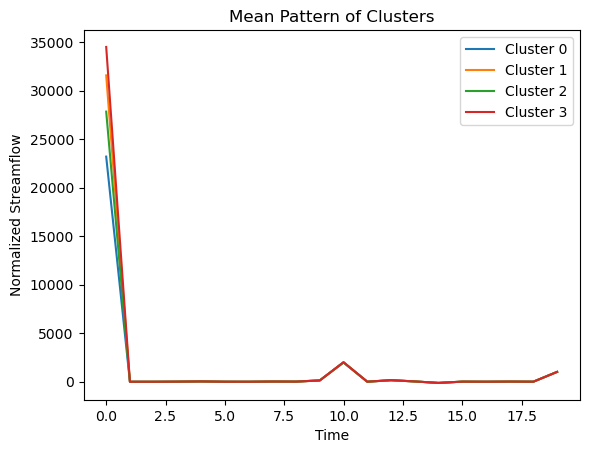

In [34]:
### visualize clusters
plt.plot(cluster_pattern.T)
plt.ylabel('Normalized Streamflow')
plt.xlabel('Time')
plt.title('Mean Pattern of Clusters')
plt.legend([f'Cluster {i}' for i in range(n_clusters)])

## K-means clustering